In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv("../../data/v0_2.csv.gz", 
                 dtype=dict(Provenance="string", RelatedWorks="string"))

# TODO: save & load DF s.t. these lines are not necessary here                
df["ObjectID"] = df.ObjectID.astype("int")
df = df.set_index("ObjectID")

In [ ]:
df2 = df[(df.BeginISODate+df.EndISODate) > 0]

df2.apply(lambda r: len(str(r.Title) + str(r.Description)) > 6, axis="columns").sum()/df2.shape[0]

In [ ]:
type(df2.iloc[0].Description)

In [ ]:

import spacy
from nltk import Tree

nlp = spacy.load("nl_core_news_sm")

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_
    
doc = nlp(df.Description.dropna().iloc[0])
print(doc)
[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

In [ ]:
from spacy import displacy
displacy.render(doc, style='dep')

In [ ]:
[nlp(t) for t in tqdm(df.Description) if isinstance(t, str)]

---
# Search

In [ ]:
kws = "" # "hello, goodbye"
prep_kws = "|".join(kws.lower().replace(", ", ",").split(","))
        
if (not kws.strip()) or (not prep_kws):
    does_contain = [True]*df.shape[0]
else:
    print("what")
    
print(does_contain)

In [ ]:
from urllib.parse import unquote

unquote('"objectKeywords"%3A""%2C"objectStartDate"%3A""%2C"objectEndDate"')

---
# Dates

 1. make all dates at least 1 (because python cannot deal with years <= 0)  
    (or drop non-positive dates)  
    (drop objects with EndISODate <= 0 in any case (doesn't make any sense))  
 
 2. convert all year values to %Y-%m-%d format (expected by Werner's API)  
    (by using datetime.strptime; allows comparison with > )  

In [ ]:
from datetime import datetime
frmt = "%Y-%m-%d"
start_year, end_year = datetime.strptime("2011-02-01", frmt), datetime.strptime("2013-10-02", frmt)

In [ ]:
(start_year.year > df.BeginISODate).sum()

In [ ]:
df.BeginISODate[(df.BeginISODate > 1500)].hist(bins=100)

### 1.

In [ ]:
df = df[df.EndISODate > 0]

# drop
df = df[df.BeginISODate > 0]

# change
df["BeginISODate"] = df.BeginISODate.replace(0, 1)

### 2.

In [ ]:
df["start_date"] = df.BeginISODate.astype(str).str.zfill(4).apply(lambda s: dt.strptime(s, "%Y"))
df["end_date"] = df.EndISODate.astype(str).str.zfill(4).apply(lambda s: dt.strptime(s, "%Y"))

---
# Keyword Search Dev

In [ ]:
kws = "Maarten Sint"
prep_kws = "|".join(kws.lower().replace(", ", ",").split(","))

In [ ]:
prep_kws

In [ ]:
d = dict(a=)

d.get("a", False)

In [ ]:
def f(**kwargs):
    print(kwargs)
    
    
d = dict(a=13)
f(a=0, **d)

---
# Integrating TypicalityEngine

In [ ]:
from src.datasets import NMvW
from src.engines.TypicalityEnginev0 import Typicality, TypicalityEngine

NMvW.data = NMvW.data.iloc[:10000]

In [ ]:
typE = TypicalityEngine(id_="TypicalityEnginev0",
                           name="TypicalityEngine/v0",
                           dataset=NMvW,
                           params=[],
                       from_saved=False)

In [ ]:
texts = NMvW.data.sample(frac=0.3).fillna("")

typs, details = typE.score_and_detail(texts)

In [ ]:
import seaborn as sns
sns.histplot(typs, color="blue")

In [ ]:
details.iloc[-1]

In [ ]:
import joblib
joblib.dump(typE.typicality, "test.pkl")

In [ ]:
import joblib
joblib.dump(typE, "test.pkl")

---

In [ ]:
import joblib
typ2 = joblib.load("test.pkl")

In [ ]:
texts = NMvW.data.sample(frac=0.3).fillna("")
typs2, details2 = typ2.score_and_detail(texts)

In [ ]:
typs, details = typE.score_and_detail(texts)

In [ ]:
(typs == typs2)

# Fast Iteration over Results

In [ ]:
df = pd.read_csv("../../data/v0_2.csv.gz", 
                 dtype=dict(Provenance="string", RelatedWorks="string"))

# TODO: save & load DF s.t. these lines are not necessary here                
df["ObjectID"] = df.ObjectID.astype("int")
df = df.set_index("ObjectID")

In [ ]:
ids = df.index.astype("string")
titles = df.Title.fillna("").astype("string")
thumbnails = pd.Series([""]*df.shape[0], 
                       name="Thumbnail",
                      index=df.index).astype("string")

In [ ]:
r = pd.concat([titles, thumbnails], axis=1)
r.index, ids

In [ ]:
r#.astype("string")

In [ ]:
lens = []
for i, row in tqdm(r.to_dict("index").items()):
    lens.append(sum(map(len, row.values())))

In [ ]:
lens = []
for i in tqdm(range(r.shape[0])):
    lens.append(sum(map(len, r.iloc[i])))

In [ ]:
r_ = r.apply(lambda col: col.str.replace(" ", "X"), axis=0)
r_.columns = [c + "X" for c in r_.columns]
r2 = pd.concat([r, r_], axis=1)

In [ ]:
t = pd.Series(np.random.random(size=df.shape[0]), index=df.index)

In [ ]:
t.iloc[0].round(3)

---
# TypicalityEngine Value Range

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
scores = pd.read_csv("/home/valentin/Desktop/scores.csv").set_index("ObjectID")["score"]
score_details = pd.read_csv("/home/valentin/Desktop/score_details.csv").set_index("ObjectID")
score_details = score_details["score_details"]

In [ ]:
_=plt.hist(scores, bins=100)
# _=plt.hist((1/scores)-1, bins=100)

In [ ]:
(scores < 100).sum()/scores.shape[0]

_= plt.hist(scores[(scores > 0) & (scores < 1)], bins=100)
# plt.xlim((0.95, 0.98))

In [ ]:
df.loc[.index]

In [ ]:
(df.fillna("").loc[scores[scores.between(0.96, 0.97)].index].Title.str.len() > 10)

In [ ]:
unnormed = (1/scores)-1

sns.histplot(unnormed.abs())

In [ ]:
plt.plot(1/(np.linspace(0., 10000., 1000)+1)**2)
plt.plot(1/(np.linspace(0., 10000., 1000)+1)**0.5)

plt.plot(1/np.log(np.linspace(0., 10000., 1000)+1))
# plt.plot(np.linspace(0., 1000., 1000)/(np.linspace(0., 1000., 1000).sum()))

# plt.ylim((0, 1))

In [ ]:
plt.hist(1/(unnormed.abs()+1))

In [ ]:
z = (unnormed - unnormed.mean())/(unnormed.var()**0.5)

sns.histplot(z)

In [ ]:
# unnormed = scores

def norm(v):
    return (v - v.min())/(v.max() - v.min())

normed = np.log(norm(norm(unnormed))+1)

sns.histplot(normed)

## Value Range of Score Details

In [ ]:
score_details = score_details.progress_apply(eval)

In [ ]:
score_details.iloc[10]

In [ ]:
(v-v.min())/(v.max() - v.min())

In [ ]:
d = {k: v for smalld in score_details for k, v in smalld.items()}

In [ ]:
def percentile_norm(v, q=99.5):
        return (v - np.percentile(v, 100-q))/(np.percentile(v, q) - np.percentile(v, 100-q))

vals = np.asarray([d[k] for k in sorted(d)])
abs_vals = abs(vals)
norm_vals = percentile_norm(abs(vals), q=99.)

In [ ]:
d_new = dict(zip(sorted(d), 1-norm_vals))

sorted(d_new.items(), key=lambda tup: tup[1])[-50:]

In [ ]:
_=plt.hist(vals, bins=100, histtype="step", lw=2)
_=plt.hist(abs_vals, bins=100, color="r", histtype="step", lw=2)
_=plt.hist(norm_vals, bins=100, color="green", histtype="step", lw=2)
_=plt.hist(1-norm_vals, bins=100, color="grey", histtype="step", lw=2)

# plt.xscale("log")
plt.yscale("log")
plt.xlim((-5, 5))

# for q in np.linspace(0, 100, 10):
#     plt.axvline(x=np.percentile(vals, q), label=str(q), c="r")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
pd.Series(1-norm_vals).describe()

In [ ]:
sorted(d.items(), key=lambda tup: tup[1])[:50]

In [ ]:
a = np.asarray([v for d in tqdm(score_details) for v in d.values()])

In [ ]:
_=plt.hist(a, bins=50)

In [ ]:
def percentile_norm(v, q=99.5):
        return (v - np.percentile(v, 100-q))/(np.percentile(v, q) - np.percentile(v, 100-q))
    
_=plt.hist(percentile_norm(a), bins=50)

# Search Parameters

In [ ]:
df.AATCN.str.replace(" (doc.)", "", regex=False).value_counts()

---
# ContentLengthEngine Dev

In [ ]:
lengths = df.fillna("").progress_apply(lambda r: len(r.Title) + len(r.Description), axis="columns")

In [ ]:
_=plt.hist(lengths/1000, bins=5000)
plt.xlim((-0.4, 1.))

In [ ]:
_= plt.hist((lengths[lengths.between(0, 1000)]+1), bins=100)

In [ ]:
for m in np.linspace(100, 20000, 200):
    plt.plot([m], [lengths[lengths.between(0, m)].shape[0]/lengths.shape[0]], ".")
    
plt.xlim((0, 1000))
plt.ylim((0.8, 1.0))

In [ ]:
from src.engines.ContentLengthEnginev0 import ContentLengthEngine

cl_eng = ContentLengthEngine(id_="ContentLengthEnginev0",
                            name="ContentLengthEngine/v0",
                            dataset=df,
                            params=[])

In [ ]:
scores, details = cl_eng.score_and_detail(df)
scores = scores/cl_eng.max_len

In [ ]:
scores.hist(bins=2000)
plt.xlim((-0.1, 1.))

In [ ]:
scores

In [ ]:
df.progress_apply(lambda r: len(r), axis="columns", desc="somthing")

---

In [9]:
import numpy as np
sorted(((i, np.sin(i**0.5)) for i in range(10)), key=lambda t:t[1])[-2:]

[(3, 0.9870266449903538), (2, 0.9877659459927356)]

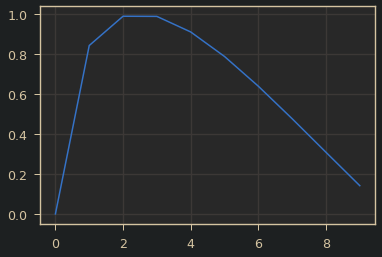

In [6]:
import matplotlib.pyplot as plt

plt.plot([np.sin(i**0.5) for i in range(10)])

---
# Dealing with Images

In [3]:
imgs = pd.read_excel("/home/valentin/Desktop/Primaire afbeeldingen.xlsx")

In [4]:
# len(set(df.index) & set(imgs.ObjectID))

imgs = imgs.set_index("ObjectID")

In [18]:
imgs["suffix URL"].iloc[0]

'&width=240&height=200&borderwidth=1&borderheight=1&bordercolor=e8e8e8&bg=f8f8f8&passepartoutwidth=16&passepartoutheight=16&passepartoutcolor=f8f8f8&cache=yes'

In [19]:
"https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/NMVW//7007-8b.jpg&width=240&height=200&borderwidth=1&borderheight=1&bordercolor=e8e8e8&bg=f8f8f8&passepartoutwidth=16&passepartoutheight=16&passepartoutcolor=f8f8f8&cache=yes"


'https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/NMVW//7007-8b.jpg&width=240&height=200&borderwidth=1&borderheight=1&bordercolor=e8e8e8&bg=f8f8f8&passepartoutwidth=16&passepartoutheight=16&passepartoutcolor=f8f8f8&cache=yes'

In [5]:
thumb = "&width=256&height=256&cache=yes"
full = "&width=720&height=720&cache=yes"

def img_or_nothing(o_id):
    try:
        # possibly: KeyError
        row = imgs.loc[o_id]
        
        thumb_url = row["prefix URL"] + row["FileName"] + thumb #+ row["suffix"]
        full_url = row["prefix URL"] + row["FileName"] + full
        
        # URLs might be faulty --> catch? or let front-end catch it?
        
        return thumb_url, full_url
    except KeyError:
        return "", ""

In [6]:
ls = [(i, *img_or_nothing(i)) for i in tqdm(df.index)]

100%|██████████████████████████████████████████████████████████████████████| 146694/146694 [02:35<00:00, 941.33it/s]


In [54]:
ls[10]

(18,
 'https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/TM//TM-0-113a.jpg&width=256&height=256&cache=yes',
 'https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/TM//TM-0-113a.jpg&width=720&height=720&cache=yes')

In [31]:
imgs["prefix URL"].iloc[-1]

'\\\\rmvservnas5\\TMSMedia\\Inventariskaarten\\WM'

In [42]:
r = imgs.iloc[0]
r["prefix URL"], r["FileName"], r["suffix URL"]

thumb = "&width=256&height=256&cache=yes"
full = "&width=720&height=720&cache=yes"

('https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/TM//',
 'TM-0-104.jpg',
 '&width=240&height=200&borderwidth=1&borderheight=1&bordercolor=e8e8e8&bg=f8f8f8&passepartoutwidth=16&passepartoutheight=16&passepartoutcolor=f8f8f8&cache=yes')

In [ ]:
https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/NMVW//7007-8b.jpg&width=720&height=720&cache=yes

In [10]:
img_df = pd.DataFrame(ls, columns=["ObjectID", "thumbnail_URL", "img_URL"]).set_index("ObjectID")

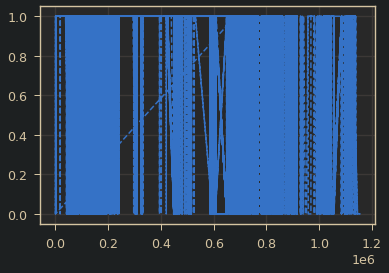

In [26]:
import matplotlib.pyplot as plt
plt.plot((img_df.img_URL.str.len() > 0).astype("int"), "--")

In [29]:
img_df.to_csv("image_URLs.csv", index=True)

In [34]:
img_df.loc[df.index[0:2]].thumbnail_URL

ObjectID
2    
5    
Name: thumbnail_URL, dtype: object

In [48]:
img2 = pd.read_csv("../../data/image_URLs.csv")

img2.fillna("")

,ObjectID,thumbnail_URL,img_URL
0,2,,
1,5,,
2,8,,
3,9,https://collectie.wereldculturen.nl/cc/imagepr...,https://collectie.wereldculturen.nl/cc/imagepr...
4,10,,
...,...,...,...
146689,1140385,,
146690,1140386,,
146691,1140388,,
146692,1140389,,


In [42]:
import json

with open("/home/valentin/Desktop/search.json") as handle:
    f = handle.read()
    x = json.loads(f)

{'attributes': ['BeginISODate', 'EndISODate', 'Department', 'Classification'],
 'results': [{'id': '1373',
   'name': 'WOONHUIS VAN DE ADMINISTRATEUR OP DE TABAKSPLANTAGE PAJA BAKONG.',
   'thumbnail_url': 'https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/TM//TM-60001563.jpg&width=256&height=256&cache=yes',
   'values': ['1885-01-01',
    '1888-01-01',
    'Insulair Zuidoost-Azië',
    'Audiovisuele collectie'],
   'x': [0.389, 0.198, 0.636, 0.0],
   'score': 0.758,
   'score_details': {}},
  {'id': '4319',
   'name': 'STAND VAN HET AMSTERDAMSCH KANTOOR VAN INDISCHE ZAKEN (AKIZ) OP DE JAARBEURS IN BANDOENG',
   'thumbnail_url': 'https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/TM//TM-60004584.jpg&width=256&height=256&cache=yes',
   'values': ['1920-01-01',
    '1926-01-01',
    'Insulair Zuidoost-Azië',
    'Audiovisuele collectie'],
   'x': [0.602, 0.455, 0.636, 0.0],
  

In [45]:
f[38220:38250]

'thumbnail_url": NaN, "values":'